# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [23]:
import cv2
import math
import numpy as np
from scipy.spatial import distance
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image.

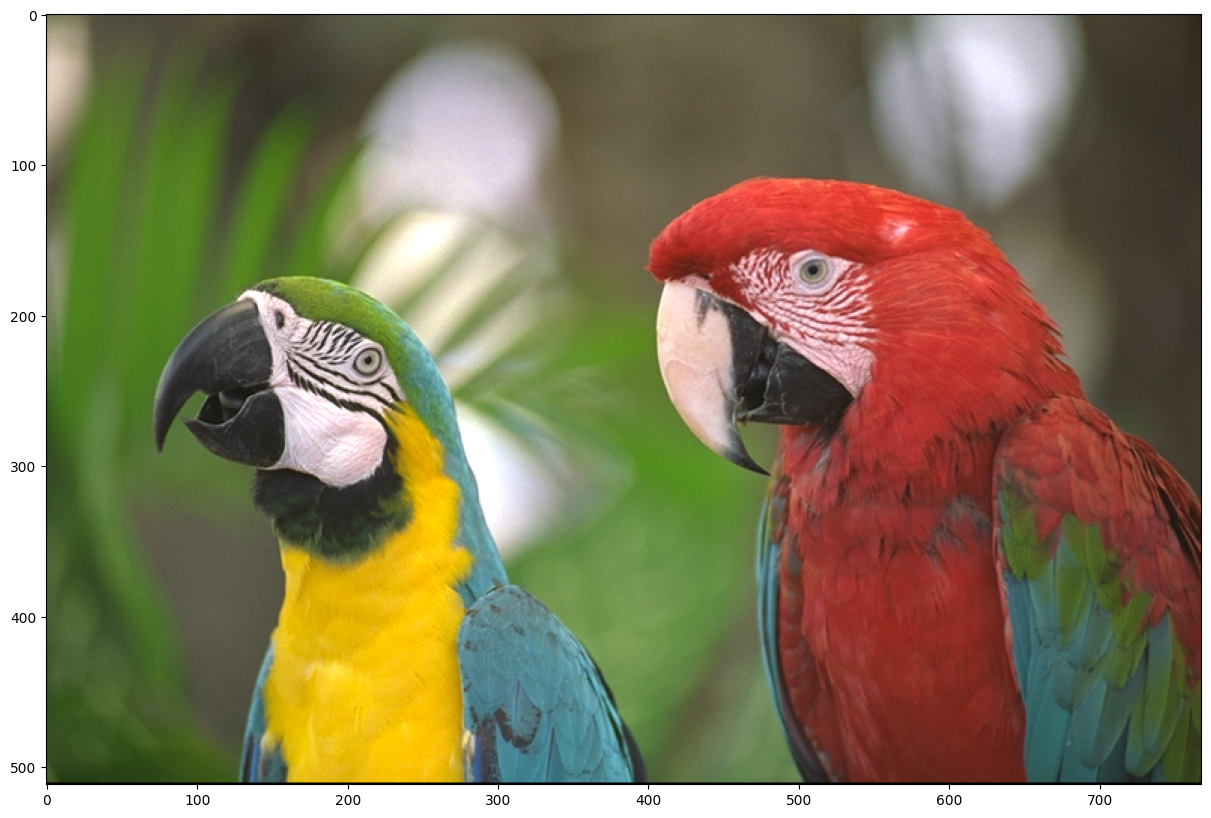

In [24]:
# Load image
img = cv2.imread('./data/kodim23.png')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

Let's start with gray tones first.

In [25]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [255, 255, 255]])
# colors = np.array([[0, 0, 0],
#                    [64, 64, 64],
#                    [192, 192, 192],
#                    [255, 255, 255]])
# colors = np.array([[0, 0, 0],
#                     [8, 8, 8],
#                    [16, 16, 16],
#                    [24, 24, 24],
#                    [32, 32, 32],
#                    [40, 40, 40],
#                    [48, 48, 48],
#                    [64, 64, 64],
#                    [72, 72, 72],
#                    [80, 80, 80],
#                    [88, 88, 88],
#                    [96, 96, 96],
#                    [104, 104, 104],
#                    [112, 112, 112],
#                    [120, 120, 120],
#                    [128, 128, 128],
#                    [136, 136, 136],
#                    [144, 144, 144],
#                    [152, 152, 152],
#                    [160, 160, 160],
#                    [168, 168, 168],
#                    [176, 176, 176],
#                    [184, 184, 184],
#                     [192, 192, 192],
#                    [200, 200, 200],
#                    [208, 208, 208],
#                    [216, 216, 216],
#                    [224, 224, 224],
#                    [232, 232, 232],
#                    [240, 240, 240],
#                    [248, 248, 248],
#                     [255, 255, 255]])

Using the colour pallette, let's quantize the original image.

In [4]:
# Cast the image to float
img = img.astype(np.float32)

# Prepare for quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)

# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = list(img[r, c, :])
        
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        best_dst = 255
        for color in colors:
            dst = abs(distance.euclidean(pixel, color))
            
            if dst <= best_dst:
                best_dst = dst
                new_pixel = color
    
        # Apply quantization
        quantized[r, c, :] = new_pixel

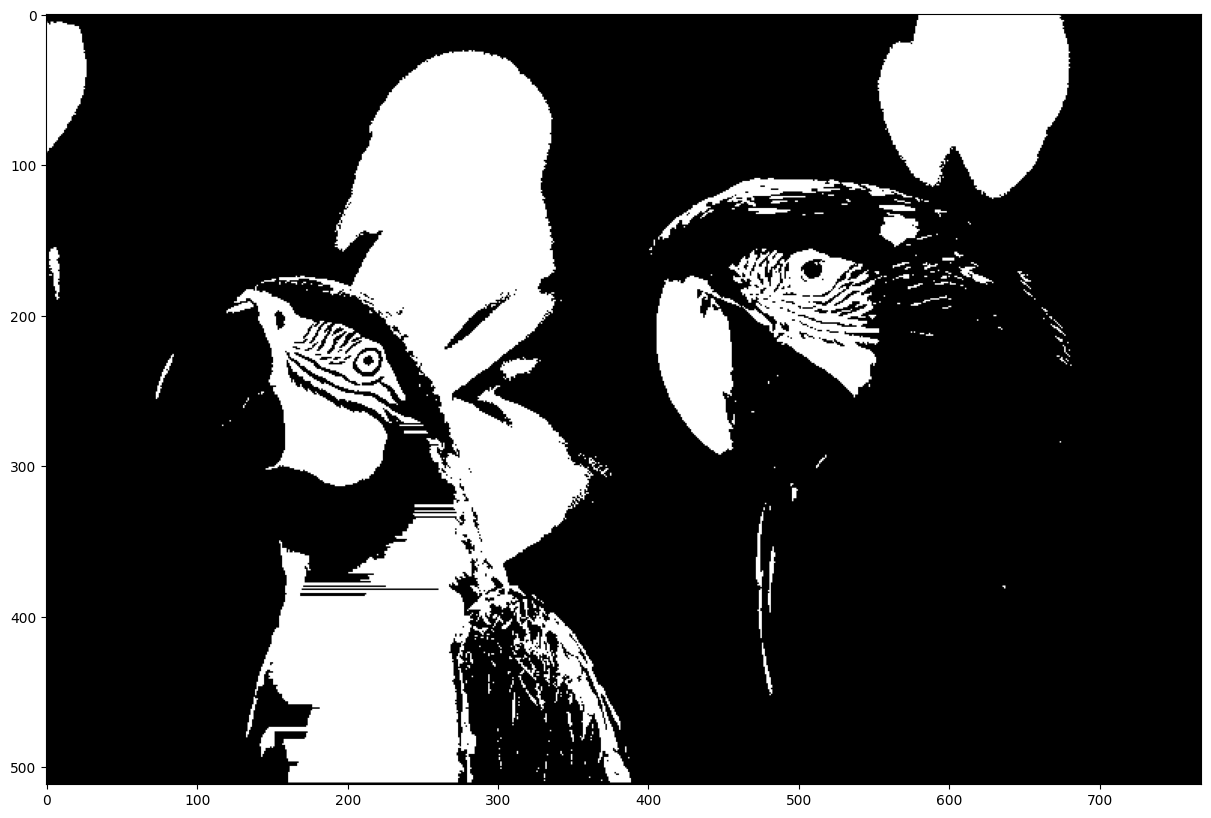

In [5]:
# Show quantized image (don't forget to cast back to uint8)
quantized = quantized.astype(np.uint8)

plt.imshow(quantized)

In [7]:
# Compute average quantization error
def psnr(ref, target):
    error = ref.astype(np.float32) - target.astype(np.float32)
    mse = np.mean(error**2)
    return 10 * np.log10((255**2)/mse)

avg_quant_error = psnr(img, quantized)
print('PSNR', avg_quant_error, 'dB')

PSNR 8.773940881983027 dB


#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [14]:
# Make a temporal copy of the original image, we will need it for error diffusion
img_tmp = np.copy(img)
dithering = np.zeros_like(img)

for r in range(0, rows - 1):
    for c in range(1, cols - 1):
        # Extract the original pixel value
        pixel = img_tmp[r, c, :]
        
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        max_distance = 255
        for color in colors:
            p_distances = pixel - color
            p_distances = np.power(p_distances, 2)
            dst = abs(p_distances[0] + p_distances[1] + p_distances[2])
#             dst = abs(distance.euclidean(pixel, color))
            if dst <= max_distance:
                max_distance = dst
                new_pixel = color
        img_tmp[r, c, :] = new_pixel
        quant_error = new_pixel - pixel
        img_tmp[r, c + 1, :] = img_tmp[r, c + 1, :] + quant_error * 7 / 16
        img_tmp[r + 1, c - 1, :] = img_tmp[r + 1, c - 1, :] + quant_error * 3 / 16
        img_tmp[r + 1, c, :] = img_tmp[r + 1, c, :] + quant_error * 5 / 16
        img_tmp[r + 1, c + 1, :] = img_tmp[r + 1, c + 1, :] + quant_error * 1 / 16
        
        # Apply dithering
        dithering[r, c, :] = new_pixel
        
        dithering = dithering.astype(np.uint8)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1525a1300>)

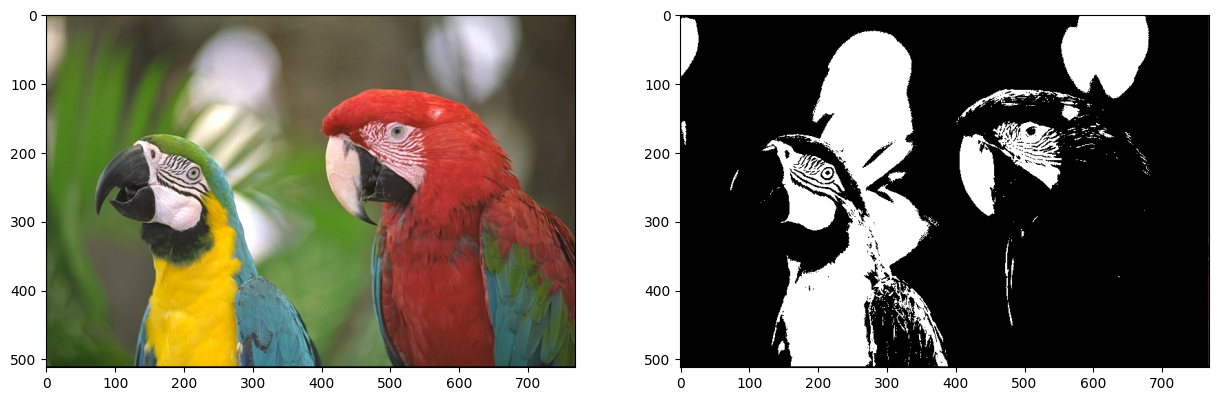

In [26]:
# Show quantized image (don't forget to cast back to uint8)
# plt.subplot(121), plt.imshow(quantized)   # optimally quantized
# plt.subplot(122), plt.imshow(dithering)   # dithering

def floydDitherspeed(img_array):
    height, width, _ = img_array.shape
    for y in range(0, height-1):
        for x in range(1, width-1):
            old_pixel = img_array[y, x, :]
            max_distance = 195075
            for color in colors:
                p_distances = old_pixel - color
                p_distances = np.power(p_distances, 2)
                distance = abs(p_distances[0] + p_distances[1] + p_distances[2])
                if distance <= max_distance:
                    max_distance = distance
                    new_pixel = color
            img_array[y, x, :] = new_pixel
            quant_error = new_pixel - old_pixel
            img_array[y, x+1, :] =  img_array[y, x+1, :] + quant_error * 7/16
            img_array[y+1, x-1, :] =  img_array[y+1, x-1, :] + quant_error * 3/16
            img_array[y+1, x, :] =  img_array[y+1, x, :] + quant_error * 5/16
            img_array[y+1, x+1, :] =  img_array[y+1, x+1, :] + quant_error * 1/16
    return img_array

i = floydDitherspeed(np.copy(img))

plt.subplot(121), plt.imshow(img.astype(np.uint8))   # optimally quantized
plt.subplot(122), plt.imshow(i.astype(np.uint8))   # dithering

In [12]:
# Compute average quantization error for dithered image
avg_dith_error = psnr(img, dithering)
print('PSNR', avg_dith_error, 'dB')

PSNR 1.3157833530641412 dB


### Questions
* Which image has higher quantization error? Optimally quantized or dithered?

**Dithered has higher quantization error (PSNR is smaller), but looks better then quantized**

* Which image looks better to you?

***Dithered image looks better due to a smoother (blurred) gradient transition***

* Can you repeat the same process using only two colours: black and white? Show me :-)

***Blank image (image with one color)***

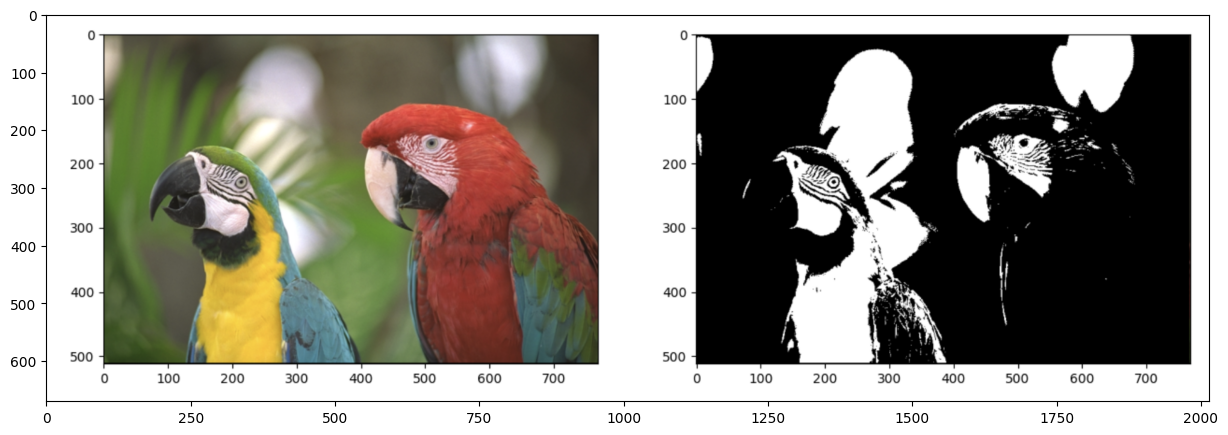

In [28]:
# Result for two colors black and white (right image)
img = cv2.imread('./data/black_and_white.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

In [ ]:
from sklearn.cluster import KMeans

(h, w, c) = img.shape
img2D = img.reshape(h * w, c)
# kmeans = KMeans(n_clusters=16).fit(img2D)
# kmeans = KMeans(n_clusters=32).fit(img2D)
kmeans = KMeans(n_clusters=256).fit(img2D)
colors = kmeans.cluster_centers_.round(0).astype(int)

print(colors)

In [ ]:
# Make a temporal copy of the original image, we will need it for error diffusion
img_tmp = np.copy(img)
dithering = np.zeros_like(img)
rows, cols, channels = img.shape

for r in range(0, rows - 1):
    for c in range(1, cols - 1):
        # Extract the original pixel value
        pixel = img_tmp[r, c, :]
        
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        max_distance = 255
        new_pixel = [0, 0, 0]
        for color in colors:
            p_distances = pixel - color
            p_distances = np.power(p_distances, 2)
            dst = abs(p_distances[0] + p_distances[1] + p_distances[2])
            if dst <= max_distance:
                max_distance = dst
                new_pixel = color
        img_tmp[r, c, :] = new_pixel
        quant_error = new_pixel - pixel
        img_tmp[r, c + 1, :] = img_tmp[r, c + 1, :] + quant_error * 7 / 16
        img_tmp[r + 1, c - 1, :] = img_tmp[r + 1, c - 1, :] + quant_error * 3 / 16
        img_tmp[r + 1, c, :] = img_tmp[r + 1, c, :] + quant_error * 5 / 16
        img_tmp[r + 1, c + 1, :] = img_tmp[r + 1, c + 1, :] + quant_error * 1 / 16
        
        # Apply dithering
        dithering[r, c, :] = new_pixel
        
        dithering = dithering.astype(np.uint8)
        
plt.subplot(121), plt.imshow(img)   # optimally quantized
plt.subplot(122), plt.imshow(dithering)   # dithering

In [14]:
# Compute average quantization error for dithered image
avg_dith_error = psnr(img, dithering)
print('PSNR', avg_dith_error, 'dB')

NameError: name 'psnr' is not defined

Apply FS dithering the same way you did before.
* How does the result look like to you?

**Not good, aspecialy blured background. Count of colors are too small.**

* What happens if we use 32 colours?

**Better but still not good.**

* And what happens if we use 256 colours?

**Now it looks good**